# Librerias 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Ruido Sal y Pimienta

In [2]:
def add_salt_and_pepper_noise(img, prob=0.1):
    noisy = img.clone()
    num_pixels = img.numel()
    num_salt = int(num_pixels * prob / 2)
    num_pepper = int(num_pixels * prob / 2)
    
    # Añadir sal (pixeles a 1)
    coords_salt = [torch.randint(0, i, (num_salt,)) for i in img.shape]
    noisy[coords_salt] = 1.0
    
    # Añadir pimienta (pixeles a 0)
    coords_pepper = [torch.randint(0, i, (num_pepper,)) for i in img.shape]
    noisy[coords_pepper] = 0.0
    
    return noisy

# Ruido gaussiano

In [3]:
def add_gaussian_noise(img, mean=0.0, std=1):
    noise = torch.randn_like(img) * std + mean
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)  # Asegurar que los valores estén en [0, 1]

# Dataset con MNIST

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     # transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)                        

In [5]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Input [-1, +1] -> use nn.Tanh

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

# Autoencoder Aumentar Resolucion

In [7]:
class AutoencoderUpscaling(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: Reduce la resolución
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),  # N, 64, 1, 1
            nn.ReLU()
        )
        
        # Decoder: Aumenta la resolución
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # N, 1, 28, 28
            nn.ReLU(),
            nn.ConvTranspose2d(1, 1, 3, stride=2, padding=1, output_padding=1),  # N, 1, 56, 56
            nn.Sigmoid()  # Normaliza valores en [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)  # Codifica a una representación comprimida
        decoded = self.decoder(encoded)  # Decodifica y aumenta la resolución
        return decoded


In [8]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [9]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # Agregar ruido
        # noisy_img = add_salt_and_pepper_noise(img)
        noisy_img = add_gaussian_noise(img)

        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(noisy_img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, noisy_img, recon))

Epoch:1, Loss:0.0372
Epoch:2, Loss:0.0324
Epoch:3, Loss:0.0267
Epoch:4, Loss:0.0332
Epoch:5, Loss:0.0275
Epoch:6, Loss:0.0326
Epoch:7, Loss:0.0277
Epoch:8, Loss:0.0287
Epoch:9, Loss:0.0311
Epoch:10, Loss:0.0250


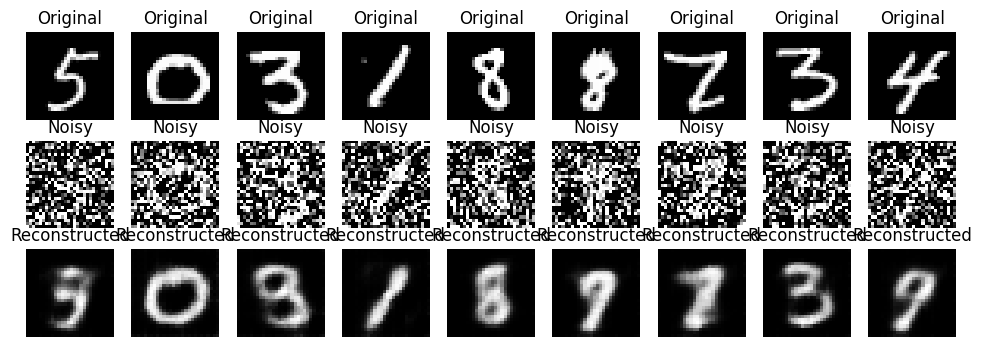

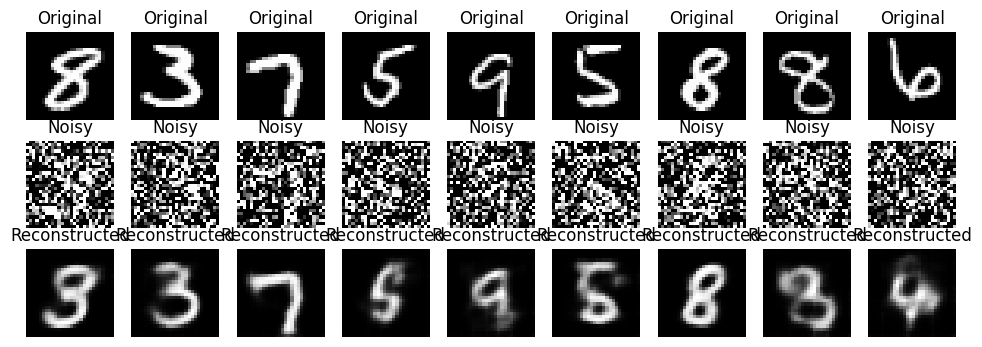

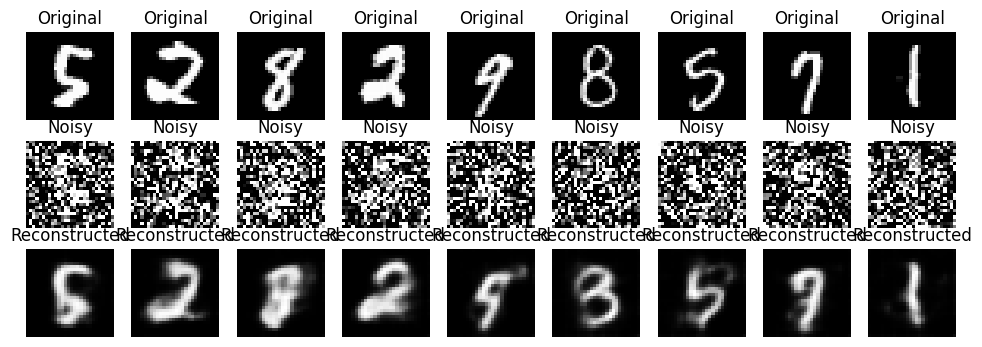

In [10]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(12, 4))
    plt.gray()
    original_imgs = outputs[k][1]
    noisy_imgs = outputs[k][2]
    recon_imgs = outputs[k][3].detach()

    for i in range(9):
        plt.subplot(3, 9, i+1)
        plt.imshow(original_imgs[i][0], cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        plt.subplot(3, 9, i+1+9)
        plt.imshow(noisy_imgs[i][0], cmap='gray')
        plt.title("Noisy")
        plt.axis('off')
        
        plt.subplot(3, 9, i+1+18)
        plt.imshow(recon_imgs[i][0], cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

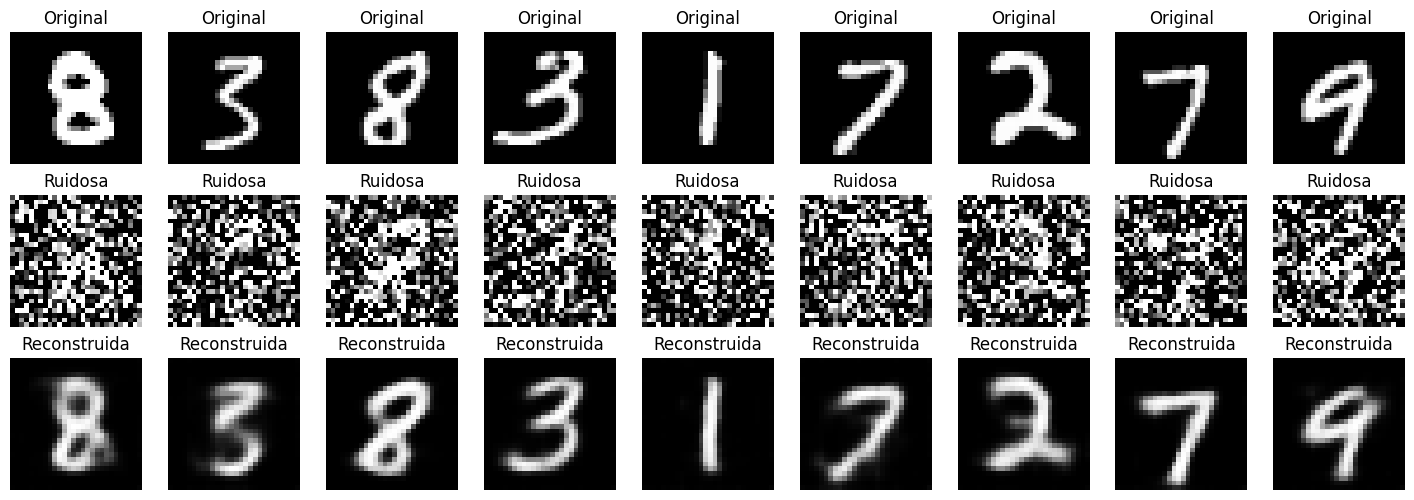

In [11]:
model.eval()  # Asegúrate de que el modelo esté en modo evaluación

# DataLoader para el conjunto de prueba
dataiter = iter(data_loader_valid)  # Crea un iterador
images, _ = next(dataiter)  # Usa next() para obtener el siguiente lote

# Agrega ruido a las imágenes del conjunto de prueba
noisy_images = add_gaussian_noise(images)  # O usa add_salt_and_pepper_noise

# Reconstruye las imágenes usando el modelo
with torch.no_grad():  # No calculamos gradientes en la evaluación
    reconstructed_images = model(noisy_images)

# Visualiza las imágenes originales, ruidosas y reconstruidas
plt.figure(figsize=(18, 6))

for i in range(9):  # Muestra las primeras 9 imágenes
    # Imagen original
    plt.subplot(3, 9, i + 1)
    plt.imshow(images[i][0].cpu().numpy(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Imagen ruidosa
    plt.subplot(3, 9, i + 1 + 9)
    plt.imshow(noisy_images[i][0].cpu().numpy(), cmap='gray')
    plt.title("Ruidosa")
    plt.axis('off')

    # Imagen reconstruida
    plt.subplot(3, 9, i + 1 + 18)
    plt.imshow(reconstructed_images[i][0].cpu().numpy(), cmap='gray')
    plt.title("Reconstruida")
    plt.axis('off')

plt.show()

# Para modelo con aumento de resolucion

In [12]:
model = AutoencoderUpscaling()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [13]:
num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    for img, _ in data_loader:
        # Agregar ruido gaussiano
        # noisy_img = add_gaussian_noise(img)

        # Reconstrucción
        recon = model(img)  # Entrada ruidosa
        
        # Reescalar imágenes originales para la comparación
        img_rescaled = F.interpolate(img, size=(56, 56), mode='bilinear', align_corners=False)
        
        # Comparar la reconstrucción con la versión reescalada de las imágenes originales
        loss = criterion(recon, img_rescaled)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.1048
Epoch:2, Loss:0.0815
Epoch:3, Loss:0.0697
Epoch:4, Loss:0.0422
Epoch:5, Loss:0.0202
Epoch:6, Loss:0.0113
Epoch:7, Loss:0.0071
Epoch:8, Loss:0.0050
Epoch:9, Loss:0.0052
Epoch:10, Loss:0.0055


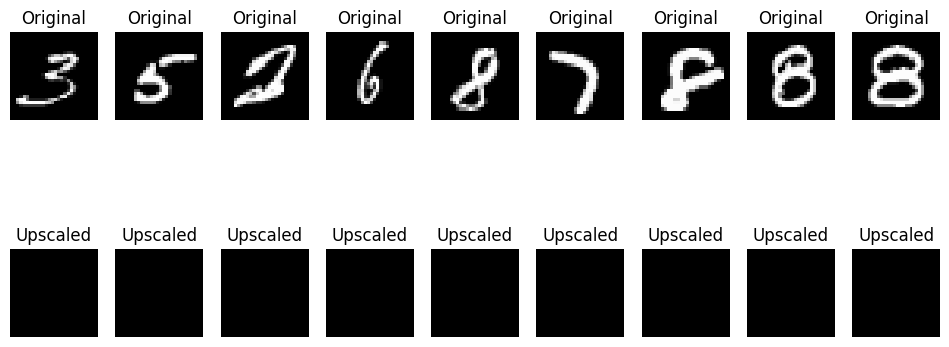

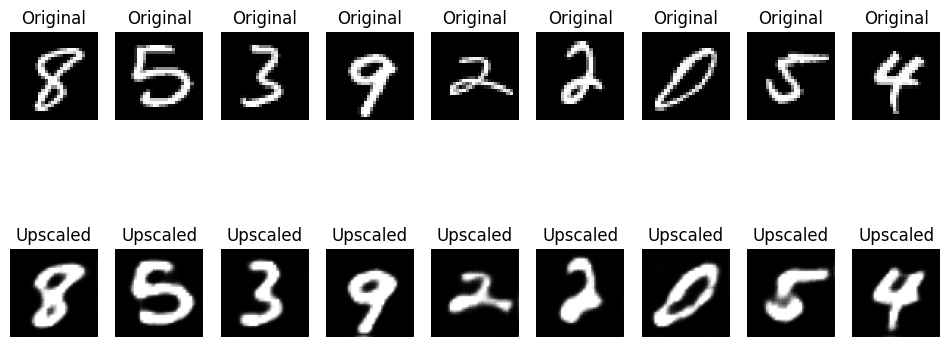

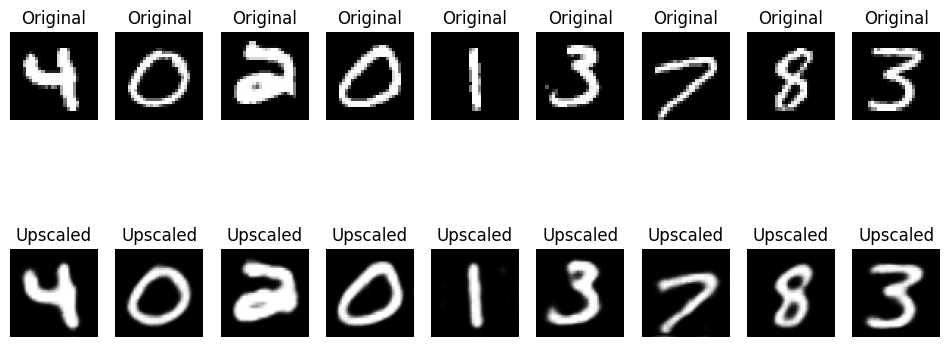

In [14]:
for k in range(0, len(outputs), 4):  # Asegura que no se exceda el tamaño de 'outputs'
    plt.figure(figsize=(12, 4))
    plt.gray()
    original_imgs = outputs[k][1]
    # noisy_imgs = outputs[k][2]
    recon_imgs = outputs[k][2].detach()
    
    for i in range(9):  # Limita las imágenes mostradas a 9
        plt.subplot(3, 9, i+1)
        plt.imshow(original_imgs[i][0], cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        #plt.subplot(3, 9, i+1+9)
        #plt.imshow(noisy_imgs[i][0], cmap='gray')
        #plt.title("Noisy")
        #plt.axis('off')
        
        plt.subplot(3, 9, i+1+18)
        plt.imshow(recon_imgs[i][0], cmap='gray')
        plt.title("Upscaled")
        plt.axis('off')
    plt.show()


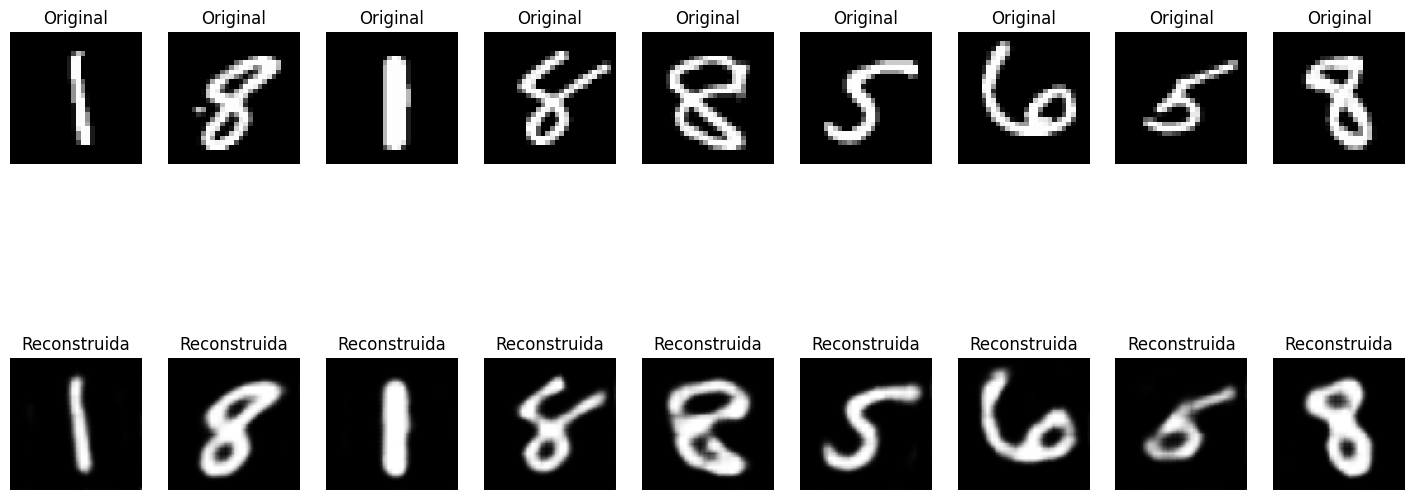

In [15]:
model.eval()  # Asegúrate de que el modelo esté en modo evaluación

# DataLoader para el conjunto de prueba
dataiter = iter(data_loader_valid)  # Crea un iterador
images, _ = next(dataiter)  # Usa next() para obtener el siguiente lote

# Reconstruye las imágenes usando el modelo
with torch.no_grad():  # No calculamos gradientes en la evaluación
    reconstructed_images = model(images)

# Visualiza las imágenes originales, ruidosas y reconstruidas
plt.figure(figsize=(18, 6))

for i in range(9):  # Muestra las primeras 9 imágenes
    # Imagen original
    plt.subplot(3, 9, i + 1)
    plt.imshow(images[i][0].cpu().numpy(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Imagen reconstruida
    plt.subplot(3, 9, i + 1 + 18)
    plt.imshow(reconstructed_images[i][0].cpu().numpy(), cmap='gray')
    plt.title("Reconstruida")
    plt.axis('off')

plt.show()